# EDA

**Problem Statement:** Build an NLP that can accurately predict if a post is from subreddit r/swimming or r/running. Evaluate the data's sentiment and determine which sub-group of athletes is happier, as well as the top 10 words/concerns respective subgroups are using most (could frame as how to speak to a swimmer or runner).


In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from nltk.corpus import stopwords
import sys

In [118]:
#Reading in the Data
swim1 = pd.read_csv('./swim feb 26.csv')
swim2 = pd.read_csv('./swim feb 27.csv')
run1 = pd.read_csv('./run feb 26.csv')
run2 = pd.read_csv('./run feb 27.csv')

In [119]:
#Renaming columns and dropping unnecessary index columns
swim1.rename(columns={'0': 'created_utc', '1': 'title', '2': 'selftext', '3': 'subreddit'}, inplace=True)
swim2.rename(columns={'0': 'created_utc', '1': 'title', '2': 'selftext', '3': 'subreddit'}, inplace=True)
run1.rename(columns={'0': 'created_utc', '1': 'title', '2': 'selftext', '3': 'subreddit'}, inplace=True)
run2.rename(columns={'0': 'created_utc', '1': 'title', '2': 'selftext', '3': 'subreddit'}, inplace=True)
swim1.drop(columns=['Unnamed: 0'], inplace=True)
swim2.drop(columns=['Unnamed: 0'], inplace=True)
run1.drop(columns=['Unnamed: 0'], inplace=True)
run2.drop(columns=['Unnamed: 0'], inplace=True)

In [120]:
#checking shape to drop the columns
print(swim1.shape, swim2.shape)
print(run1.shape, run2.shape)

(1987, 4) (1935, 4)
(1979, 4) (1934, 4)


In [121]:
#creating separate, single swim and run dataframes
swim_all = pd.concat([swim1, swim2], axis=0)
run_all = pd.concat([run1, run2], axis=0)
print(swim_all.shape, run_all.shape)

(3922, 4) (3913, 4)


In [122]:
#dropping rows if they appear as duplicates in 'title' column
swim_all.drop_duplicates(subset=['title'], inplace=True)
run_all.drop_duplicates(subset=['title'], inplace=True)
print(swim_all.shape, run_all.shape)

(2001, 4) (1800, 4)


In [123]:
#creating one dataframe of all the data
full = pd.concat([swim_all, run_all], axis=0)
full.shape

(3801, 4)

In [124]:
full.isna().sum()

created_utc       0
title             0
selftext       1054
subreddit         0
dtype: int64

In [125]:
full.dtypes

created_utc    float64
title           object
selftext        object
subreddit       object
dtype: object

In [126]:
full.columns

Index(['created_utc', 'title', 'selftext', 'subreddit'], dtype='object')

In [127]:
#Checking balance
full.subreddit.value_counts()

subreddit
Swimming    2001
running     1800
Name: count, dtype: int64

In [128]:
full['subreddit'] = full['subreddit'].map({'running': 0, 'Swimming': 1})

In [154]:
full.head()

,created_utc,title,selftext,subreddit
0,1.708961e+09,Could you recommend home gym equipment for Sma...,"I am a 90kg man but quite weak, I always feel ...",1
1,1.708957e+09,Attire,The pool I go to doesn’t really care what peop...,1
2,1.708954e+09,"Swam my first km, how to keep it up and improve?","Hi everyone,\n\nI'm in my early thirties and w...",1
3,1.708952e+09,Can anyone please tell me the name of the tech...,NaN,1
4,1.708952e+09,Y Nationals,We are headed to Greensboro for Ynats. There ...,1


In [156]:
full['selftext'].isna().sum()

1054

In [157]:
full.shape

(3801, 4)

In [144]:
#Assign ----> Ask Rowan or Tim if I can do this with multiple columns or if it needs to be a single
X = full['title']
y = full['subreddit']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2024)

In [145]:
sw = stopwords.words('english')

#Instantiating CountVectorizer
cvec = CountVectorizer(stop_words=sw)

#Fitting to corpus
cvec.fit(X_train)

#Transforming
X_train_cv = cvec.transform(X_train)
X_test_cv = cvec.transform(X_test)

In [146]:
X_train_cv.shape

(2850, 4425)

In [147]:
#Making X_train_cvec into a dataframe

X_train_df = pd.DataFrame(
    X_train_cv.toarray(), 
    columns=cvec.get_feature_names_out()
)
X_train_df.head()

,00,000,000m,00s,01,01h,02,03,04,05,...,zheng,zippers,zipup,zone,zone3,zones,zoological,zoom,zumba,zygo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [158]:
top_full = X_train_df.sum().sort_values(ascending=False).head(20)

running         305
swimming        284
first           252
marathon        244
swim            222
run             183
time            134
2024            122
today           118
2023            107
pool            103
race            101
half             96
achievements     96
ran              94
year             88
official         80
anyone           79
water            78
100              72
dtype: int64

In [177]:
swim_mask = full[full['subreddit'] == 1]
X2 = swim_mask['title']

cvec = CountVectorizer(stop_words=sw)
cvec.fit(X2)

#Transforming
X2_cv = cvec.transform(X2)
X2_cv_df = pd.DataFrame(
    X2_cv.todense(),
    columns=cvec.get_feature_names_out()
)

<Axes: >

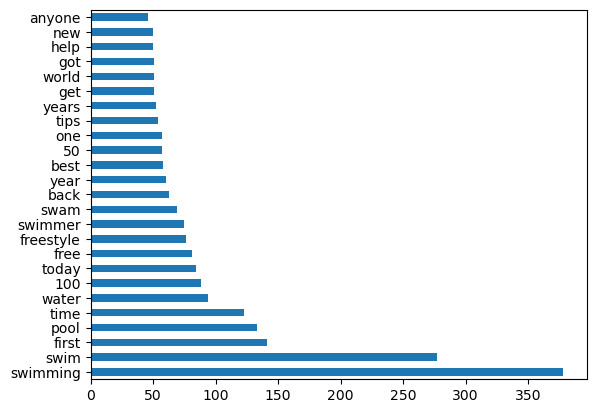

In [178]:
# plt.figure(figsize=(12,5))
# plt.barh(swim_mask.index, swim_mask, color='goldenrod');
X2_cv_df.sum().sort_values(ascending=False).head(25).plot(kind='barh')

<Axes: >

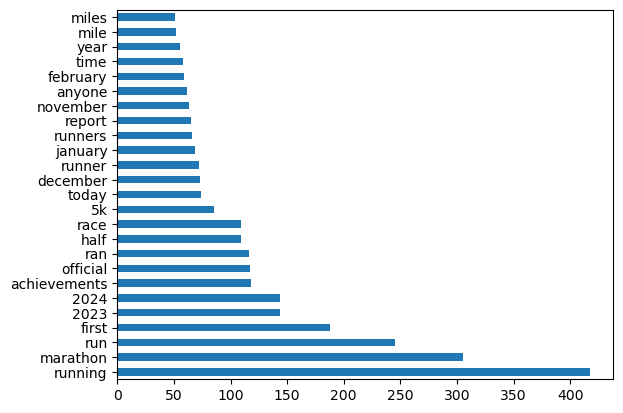

In [180]:
run_mask = full[full['subreddit'] == 0]
X2 = run_mask['title']

cvec = CountVectorizer(stop_words=sw)
cvec.fit(X2)

#Transforming
X2_cv = cvec.transform(X2)
X2_cv_df = pd.DataFrame(
    X2_cv.todense(),
    columns=cvec.get_feature_names_out()
)
X2_cv_df.sum().sort_values(ascending=False).head(25).plot(kind='barh')

To Do Next:
* train predictive model to be able to tell which subreddit
* Do sentiment analysis to see who is happier